In [162]:
import sys
sys.path.insert(0, "../")
import numpy as np
import matplotlib.pyplot as plt
import rebound
from datetime import datetime
from scipy import signal
from src.utilities.constants import rad2Deg, m2au, sec2year
from scipy.optimize import curve_fit

In [147]:
def lin_func(xs, m, b):
    return [m*x + b for x in xs]
def get_pr(o):
    return np.tan(0.5*o.inc)*np.sin(o.Omega)
def get_qr(o):
    return np.tan(0.5*o.inc)*np.cos(o.Omega)
def get_hr(o):
    return o.e*np.sin(o.pomega)
def get_kr(o):
    return o.e*np.cos(o.pomega)
def polarizing_angles(angles):
    for a in angles[:1000]:
        if a < 0:
            angles = [ang+2*np.pi for ang in angles]
            break

    polar_angles = []
    for i in range(len(angles)):
        a = angles[i]
        if i < 2000:
            a0 = polar_angles[i-1] if i > 0 else angles[0]
            while abs(a0 - a) > np.pi:
                if a>a0:
                    a-=2*np.pi
                else:
                    a+=2*np.pi
            polar_angles.append(a)
        else:
            a0 = np.mean(polar_angles[i-2000:i-1500])
            while abs(a0 - a) > np.pi:
                if a>a0:
                    a-=2*np.pi
                else:
                    a+=2*np.pi
            polar_angles.append(a)

    af = polar_angles[-1]
    if af < 0:
        fac = abs(af)//(2*np.pi) + 1
        polar_angles = [ang+fac*2*np.pi for ang in polar_angles]
    return polar_angles
def signal_strength(w, signal):
    test_times = z_data['time']
    n = len(signal)
    sin_term = abs(sum(np.sin([t* w/3600/rad2Deg for t in test_times]) * signal)/n*2)
    cos_term = abs(sum(np.cos([t* w/3600/rad2Deg for t in test_times]) * signal)/n*2)
    return np.sqrt(sin_term**2 +  cos_term**2)

def find_phase(w, signal):
    test_times = z_data['time']
    n = len(signal)
    terms = []
    phases = np.linspace(0, 2*np.pi, 1001)
    for phase in phases:
        cos_term = abs(sum(np.cos([t* w/3600/rad2Deg for t in test_times]+phase) * signal)/n*2)  
        terms.append(cos_term)
    max_term_index = np.argmax(terms)
    return phases[max_term_index], terms[max_term_index]


In [55]:
zoran_output = '/Users/bethclark/Projects/Flora_Family/docs/Zoran_prop_elmnts/v85395.fil'
z_data = {'time':[], 'a':[], 'h':[], 'k':[], 'p':[], 'q':[]}
with open(zoran_output) as f:
    for line in f.readlines()[4:]:
        d = line.split()
        z_data['time'].append(float(d[0]))
        z_data['a'].append(float(d[1]))
        z_data['h'].append(float(d[2]))
        z_data['k'].append(float(d[3]))
        z_data['p'].append(float(d[4]))
        z_data['q'].append(float(d[5]))
for key in z_data:
    z_data[key].reverse()


# Proper Elements as derived by Zoran Knezevic
|Asteroid|a|e|sin I|n(deg/yr)|g("/yr)|s("/yr)|gamma(Myr^-1)|
|-|-|-|-|-|-|-|-|
|85395|2.6622886|0.1254075|0.4737942|82.864610|6.175787|-37.967708|-1.53

In [11]:
print('a = {:.7f}'.format(np.mean(z_data['a'])))

a = 2.6622886


In [13]:
n = len(z_data['h'])
dt = 200 # years
print(n*dt)

1997800


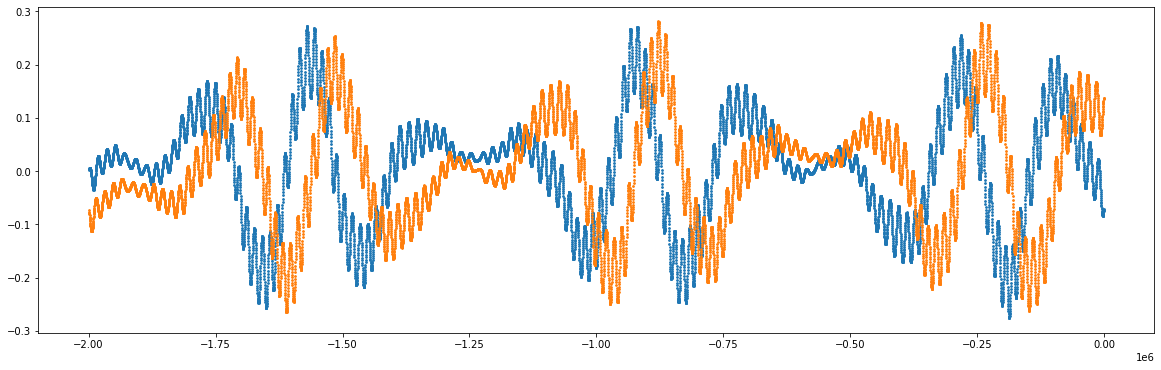

In [47]:
plt.figure(figsize=(20, 6))
plt.scatter(z_data['time'], z_data['k'], s=3)
plt.scatter(z_data['time'], z_data['h'], s=3)

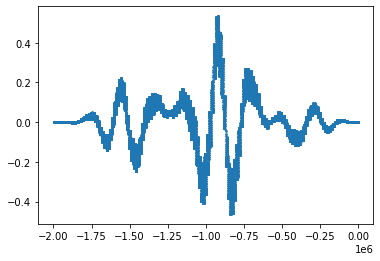

In [115]:
sig_xi = z_data['k']*(1 + np.cos([(t+1e6)*np.pi/1e6 for t in z_data['time']]))
plt.scatter(z_data['time'], z_data['k']*(1 + np.cos([(t+1e6)*np.pi/1e6 for t in z_data['time']])), s=3)

In [134]:
fhat_k_xi = np.fft.fft(sig_xi, n=n, norm=None)
more_freqs = np.linspace(1, 10, int(1e4))

strong_signal =[]
for w in more_freqs:
    strong_signal.append(signal_strength(w, sig_xi))


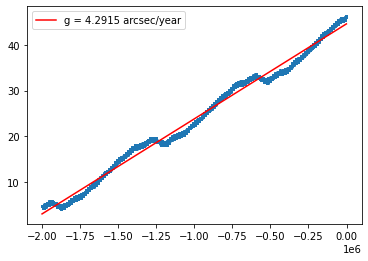

In [103]:
def polarizing_angles(angles):
    for a in angles[:1000]:
        if a < 0:
            angles = [ang+2*np.pi for ang in angles]
            break

    polar_angles = []
    for i in range(len(angles)):
        a = angles[i]
        a0 = polar_angles[i-1] if i > 0 else angles[0]
        while abs(a0 - a) > np.pi/2:
            if a>a0:
                a-=2*np.pi
            else:
                a+=2*np.pi
        polar_angles.append(a)

    af = polar_angles[-1]
    if af < 0:
        fac = abs(af)//(2*np.pi) + 1
        polar_angles = [ang+fac*2*np.pi for ang in polar_angles]
    return polar_angles
polarized_pomega = polarizing_angles(np.arctan2(z_data['h'],z_data['k']))
plt.scatter(z_data['time'], polarized_pomega, s=3)
(g, b), pcov = curve_fit(lin_func, z_data['time'], polarized_pomega)
plt.plot(z_data['time'], lin_func(z_data['time'], g, b), c = 'red', label = 'g = {:.4f} arcsec/year'.format( g*rad2Deg*3600))
plt.legend()

In [104]:
fhat_h = np.fft.fft(z_data['h'], n=n, norm=None)
psd_h = abs(fhat_h)/n*2
fhat_k = np.fft.fft(z_data['k'], n=n, norm=None)
psd_k = abs(fhat_k)/n*2
fhat_p = np.fft.fft(z_data['p'], n=n, norm=None)
psd_p = abs(fhat_p)/n*2
fhat_q = np.fft.fft(z_data['q'], n=n, norm=None)
psd_q = abs(fhat_q)/n*2
freq = (2*np.pi*rad2Deg*3600/(dt*n)) * np.arange(n)

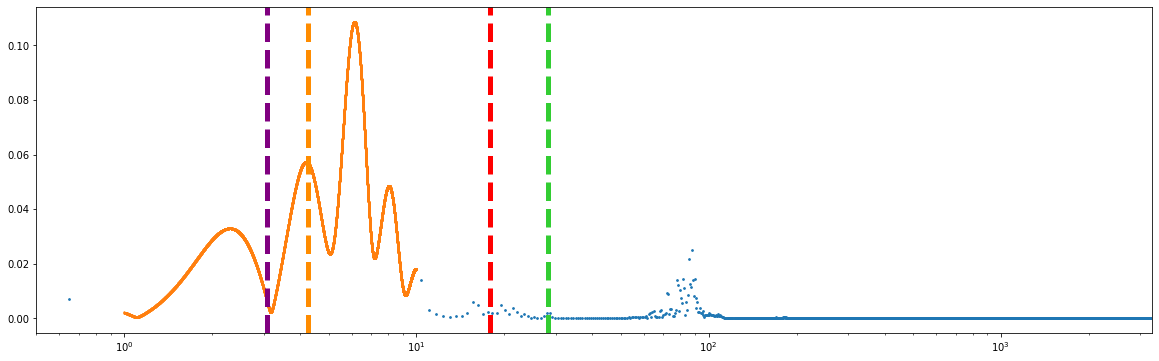

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(freq[:n//2], abs(fhat_k_xi[:n//2])/n*2, s=3)
plt.scatter(more_freqs, strong_signal, s=2)
# plt.yscale('log')
plt.xscale('log')
plt.xlim(5e-1, 3.3e3)
# plt.axvline(5.5964, c='brown', ls ='--', label = 'Theoretical: g1', lw = 5)
# plt.axvline(7.4559, c='darkkhaki', ls ='--', label = 'Theoretical: g2', lw = 5)
# # plt.axvline(g_j['g2']*rad2Deg*3600, c='darkkhaki', label='Locally Computed: g2', lw = 3)
# plt.axvline(17.3646, c='darkgreen', ls ='--', label = 'Theoretical: g3', lw = 5)
# # plt.axvline(g_j['g3']*rad2Deg*3600, c='darkgreen', label='Locally Computed: g3', lw = 3)
plt.axvline(17.9156, c='red', ls ='--', label = 'Theoretical: g4', lw = 5)
# # plt.axvline(g_j['g4']*rad2Deg*3600, c='red', label='Locally Computed: g4', lw = 3)
plt.axvline(4.2575, c='darkorange', ls ='--', label = 'Theoretical: g5', lw = 5)
# # plt.axvline(g_j['g5']*rad2Deg*3600, c='darkorange', label='Locally Computed: g5', lw = 3)
plt.axvline(28.2455, c='limegreen', ls ='--', label = 'Theoretical: g6', lw = 5)
# # plt.axvline(g_j['g6']*rad2Deg*3600, c='limegreen', label='Locally Computed: g6', lw = 3)
plt.axvline(3.0868, c='purple', ls ='--', label = 'Theoretical: g7', lw = 5)
# # plt.axvline(g_j['g7']*rad2Deg*3600, c='purple', label='Locally Computed: g7', lw = 3)
# plt.axvline(0.6726, c='deeppink', ls ='--', label = 'Theoretical: g8', lw = 5)
# # plt.axvline(g_j['g8']*rad2Deg*3600, c='deeppink', label='Locally Computed: g8', lw = 3)

In [144]:
for i, freq in enumerate(more_freqs):
    if freq>5:
        print(i)
        break

4445


In [156]:
max(strong_signal)

0.10871703885013755

In [146]:
more_freqs[1112+np.argmax(strong_signal[1112:4445])], np.max(strong_signal[1112:4445])

(4.188118811881187, 0.05730244906723381)

In [148]:
find_phase(4.188118811881187, sig_xi)

(0.21991148575128552, 0.05730219441632285)

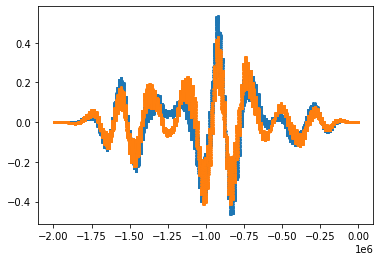

In [150]:
jupiter_removed = []
for i, time in enumerate(z_data['time']):
    subbed = z_data['k'][i] -  0.05730219441632285*np.cos(0.21991148575128552+4.188118811881187*time/3600/180*np.pi)
    jupiter_removed.append(subbed)
jupiter_removed = jupiter_removed*(1 + np.cos([(t+1e6)*np.pi/1e6 for t in z_data['time']]))
plt.scatter(z_data['time'], z_data['k']*(1 + np.cos([(t+1e6)*np.pi/1e6 for t in z_data['time']])), s=3)
plt.scatter(z_data['time'], jupiter_removed, s=3)

In [151]:
strong_signal_2 =[]
fhat_k_xi = np.fft.fft(jupiter_removed, n=n, norm=None)
for w in more_freqs:
    strong_signal_2.append(signal_strength(w, jupiter_removed))


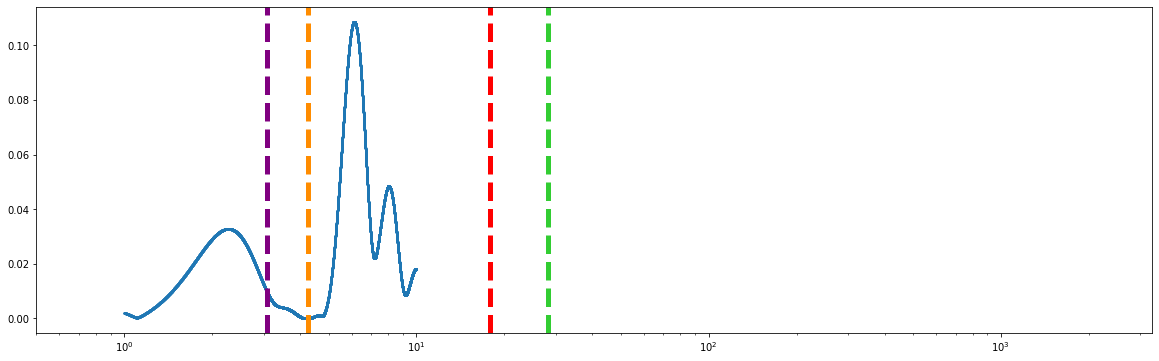

In [153]:
plt.figure(figsize=(20, 6))
# plt.scatter(freq[:n//2], abs(fhat_k_xi[:n//2])/n*2, s=3)
plt.scatter(more_freqs, strong_signal_2, s=2)
# plt.yscale('log')
plt.xscale('log')
plt.xlim(5e-1, 3.3e3)
plt.axvline(17.9156, c='red', ls ='--', label = 'Theoretical: g4', lw = 5)
plt.axvline(4.2575, c='darkorange', ls ='--', label = 'Theoretical: g5', lw = 5)
plt.axvline(28.2455, c='limegreen', ls ='--', label = 'Theoretical: g6', lw = 5)
plt.axvline(3.0868, c='purple', ls ='--', label = 'Theoretical: g7', lw = 5)

In [157]:
max(strong_signal_2), more_freqs[np.argmax(strong_signal_2)]

(0.10872987939399502, 6.123312331233123)

In [139]:
more_freqs[:3]

array([1.        , 1.00090009, 1.00180018])

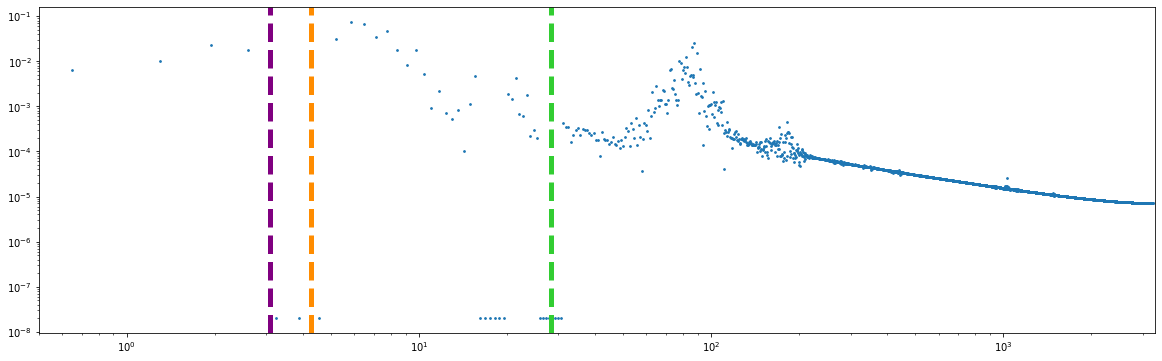

In [110]:
fundamentals = [3.0868, 4.2575, 17.9156, 28.2455]
for g in fundamentals:
    for i, w in enumerate(freq[:n//2]):
        if abs(g-w)< 0.1*g:
            fhat_h[i] = 1e-4
            fhat_k[i] = 1e-4

psd_h = abs(fhat_h)/n*2
psd_k = abs(fhat_k)/n*2
plt.figure(figsize=(20, 6))
plt.scatter(freq[:n//2], psd_k[:n//2], s=3)
plt.yscale('log')
plt.xscale('log')
plt.xlim(5e-1, 3.3e3)
# plt.axvline(5.5964, c='brown', ls ='--', label = 'Theoretical: g1', lw = 5)
# plt.axvline(7.4559, c='darkkhaki', ls ='--', label = 'Theoretical: g2', lw = 5)
# # plt.axvline(g_j['g2']*rad2Deg*3600, c='darkkhaki', label='Locally Computed: g2', lw = 3)
# plt.axvline(17.3646, c='darkgreen', ls ='--', label = 'Theoretical: g3', lw = 5)
# # plt.axvline(g_j['g3']*rad2Deg*3600, c='darkgreen', label='Locally Computed: g3', lw = 3)
# plt.axvline(17.9156, c='red', ls ='--', label = 'Theoretical: g4', lw = 5)
# # plt.axvline(g_j['g4']*rad2Deg*3600, c='red', label='Locally Computed: g4', lw = 3)
plt.axvline(4.2575, c='darkorange', ls ='--', label = 'Theoretical: g5', lw = 5)
# # plt.axvline(g_j['g5']*rad2Deg*3600, c='darkorange', label='Locally Computed: g5', lw = 3)
plt.axvline(28.2455, c='limegreen', ls ='--', label = 'Theoretical: g6', lw = 5)
# # plt.axvline(g_j['g6']*rad2Deg*3600, c='limegreen', label='Locally Computed: g6', lw = 3)
plt.axvline(3.0868, c='purple', ls ='--', label = 'Theoretical: g7', lw = 5)
# # plt.axvline(g_j['g7']*rad2Deg*3600, c='purple', label='Locally Computed: g7', lw = 3)
# plt.axvline(0.6726, c='deeppink', ls ='--', label = 'Theoretical: g8', lw = 5)
# # plt.axvline(g_j['g8']*rad2Deg*3600, c='deeppink', label='Locally Computed: g8', lw = 3)

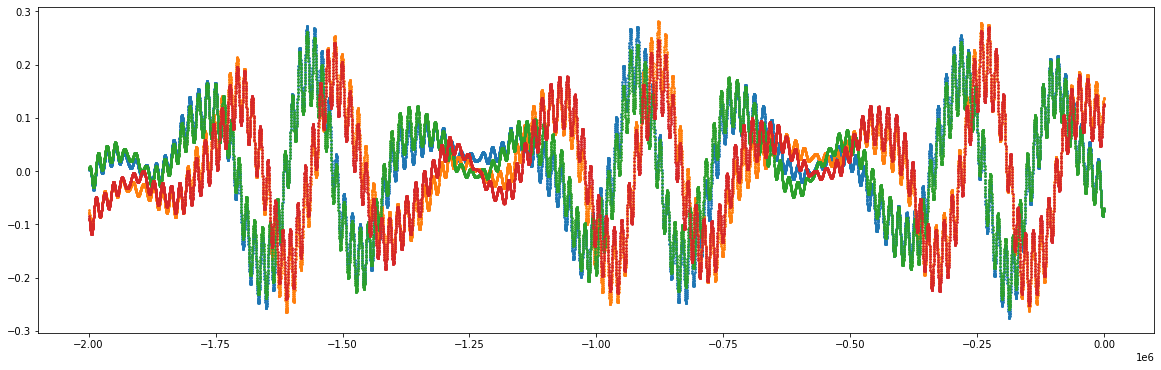

In [111]:
clean_k = np.fft.ifft(fhat_k)
clean_h = np.fft.ifft(fhat_h)
plt.figure(figsize=(20, 6))
plt.scatter(z_data['time'], z_data['k'], s=3)
plt.scatter(z_data['time'], z_data['h'], s=3)
plt.scatter(z_data['time'], clean_k, s=3)
plt.scatter(z_data['time'], clean_h, s=3)

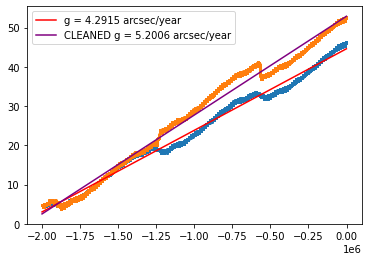

In [108]:
polarized_pomega = polarizing_angles(np.arctan2(z_data['h'],z_data['k']))
plt.scatter(z_data['time'], polarized_pomega, s=3)
(g, b), pcov = curve_fit(lin_func, z_data['time'], polarized_pomega)
plt.plot(z_data['time'], lin_func(z_data['time'], g, b), c = 'red', label = 'g = {:.4f} arcsec/year'.format( g*rad2Deg*3600))

polarized_pomega = polarizing_angles(np.arctan2(clean_h.real,clean_k.real))
plt.scatter(z_data['time'], polarized_pomega, s=3)
(g, b), pcov = curve_fit(lin_func, z_data['time'], polarized_pomega)
plt.plot(z_data['time'], lin_func(z_data['time'], g, b), c = 'purple', label = 'CLEANED g = {:.4f} arcsec/year'.format( g*rad2Deg*3600))
plt.legend()

In [82]:
clean_h[:5]

array([-0.08325634-0.01255381j, -0.08533349-0.01257686j,
       -0.08745753-0.01259559j, -0.08962327-0.01261003j,
       -0.09182023-0.01262021j])

(1.0, 60.0)

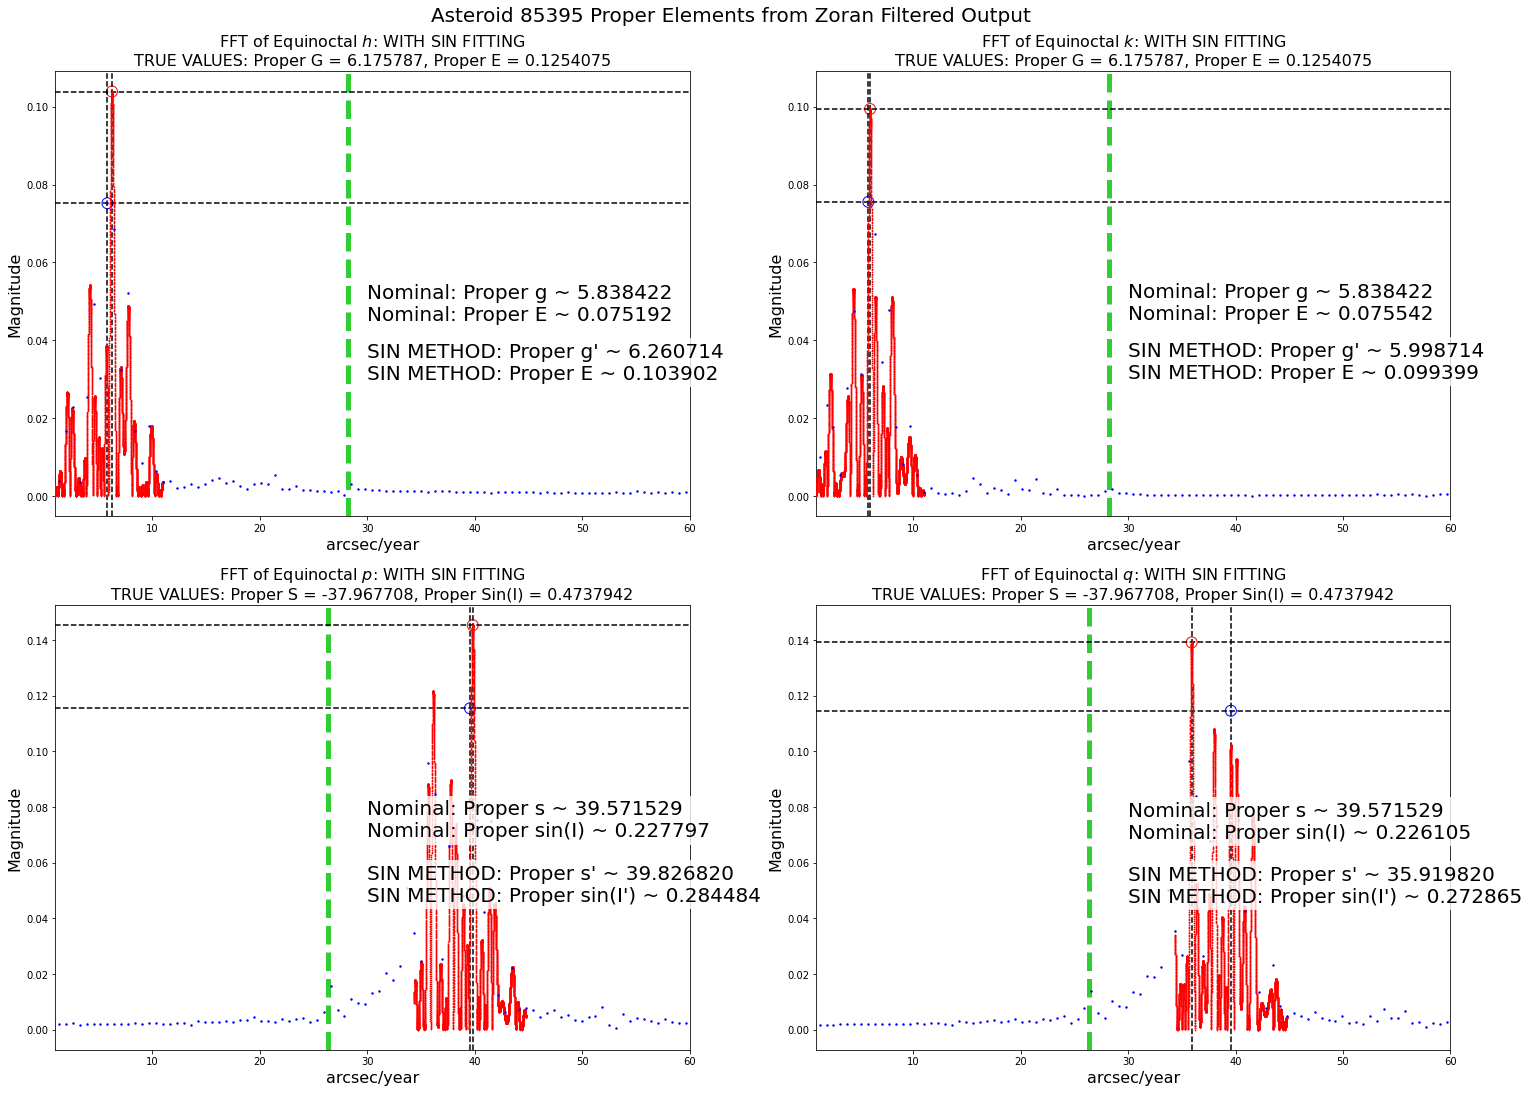

In [21]:
plt.figure(figsize=(25, 18))
plt.suptitle("Asteroid 85395 Proper Elements from Zoran Filtered Output", fontsize = 20, y=.93)

plt.subplot(2, 2, 1)
ax1 = plt.gca()
plt.axvline(28.2455, c='limegreen', ls ='--', label = 'Theoretical: g6', lw = 5)
peak_index = 1 + np.argmax(psd_h[1:n//2])
P_e = psd_h[peak_index]
P_g = freq[peak_index]
plt.scatter(P_g, P_e, s=120, facecolors='none', edgecolors='blue')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')
t = plt.text(30, psd_h[peak_index]*.6, 'Nominal: Proper g ~ {:.6f}\nNominal: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.scatter(freq, psd_h, zorder=100, s=2, c='blue')
more_freqs = np.arange(freq[peak_index-8], freq[peak_index+8], .001)
response = [signal_strength(w, z_data['h']) for w in more_freqs]
plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_e = max(response)
P_g = more_freqs[np.argmax(response)]
plt.scatter(P_g, P_e, s=120, facecolors='none', edgecolors='red')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')
t = plt.text(30, psd_h[peak_index]*.4, 'SIN METHOD: Proper g\' ~ {:.6f}\nSIN METHOD: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.title('FFT of Equinoctal $h$: WITH SIN FITTING\nTRUE VALUES: Proper G = 6.175787, Proper E = 0.1254075',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(1, 60)

plt.subplot(2, 2, 2, sharey=ax1)
ax2=plt.gca()
plt.axvline(28.2455, c='limegreen', ls ='--', label = 'Theoretical: g6', lw = 5)
peak_index = 1 + np.argmax(psd_k[1:n//2])
P_e = psd_k[peak_index]
P_g = freq[peak_index]
plt.scatter(P_g, P_e, s=120, facecolors='none', edgecolors='blue')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')
t = plt.text(30, psd_k[peak_index]*.6, 'Nominal: Proper g ~ {:.6f}\nNominal: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.scatter(freq, psd_k, zorder=100, s=2, c='blue')
more_freqs = np.arange(freq[peak_index-8], freq[peak_index+8], .001)
response = [signal_strength(w, z_data['k']) for w in more_freqs]
plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_e = max(response)
P_g = more_freqs[np.argmax(response)]
plt.scatter(P_g, P_e, s=120, facecolors='none', edgecolors='red')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')
t = plt.text(30, psd_k[peak_index]*.4, 'SIN METHOD: Proper g\' ~ {:.6f}\nSIN METHOD: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.title('FFT of Equinoctal $k$: WITH SIN FITTING\nTRUE VALUES: Proper G = 6.175787, Proper E = 0.1254075',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(1, 60)

plt.subplot(2, 2, 3, sharex=ax1)
ax3=plt.gca()
plt.axvline(26.3450, c='limegreen', ls ='--', label = 'Theoretical: s6', lw = 5)
peak_index = 1 + np.argmax(psd_p[1:n//2])
P_I = psd_p[peak_index]
P_s = freq[peak_index]
plt.scatter(P_s, P_I, s=120, facecolors='none', edgecolors='blue')
plt.axhline(P_I, ls = '--', c='k')
plt.axvline(P_s, ls = '--', c='k')
t = plt.text(30, psd_p[peak_index]*.6, 'Nominal: Proper s ~ {:.6f}\nNominal: Proper sin(I) ~ {:.6f}'.format(P_s, np.sin(np.arctan(P_I)*2)), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.scatter(freq, psd_p, zorder=100, s=2, c='blue')
more_freqs = np.arange(freq[peak_index-8], freq[peak_index+8], .001)
response = [signal_strength(w, z_data['p']) for w in more_freqs]
plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_I = max(response)
P_s = more_freqs[np.argmax(response)]
plt.scatter(P_s, P_I, s=120, facecolors='none', edgecolors='red')
plt.axhline(P_I, ls = '--', c='k')
plt.axvline(P_s, ls = '--', c='k')
t = plt.text(30, psd_p[peak_index]*.4, 'SIN METHOD: Proper s\' ~ {:.6f}\nSIN METHOD: Proper sin(I\') ~ {:.6f}'.format(P_s, np.sin(np.arctan(P_I)*2)), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.title('FFT of Equinoctal $p$: WITH SIN FITTING\nTRUE VALUES: Proper S = -37.967708, Proper Sin(I) = 0.4737942',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(1, 60)

plt.subplot(2, 2, 4, sharey=ax3, sharex=ax2)
ax4=plt.gca()
plt.axvline(26.3450, c='limegreen', ls ='--', label = 'Theoretical: s6', lw = 5)
peak_index = 1 + np.argmax(psd_q[1:n//2])
P_I = psd_q[peak_index]
P_s = freq[peak_index]
plt.scatter(P_s, P_I, s=120, facecolors='none', edgecolors='blue')
plt.axhline(P_I, ls = '--', c='k')
plt.axvline(P_s, ls = '--', c='k')
t = plt.text(30, psd_q[peak_index]*.6, 'Nominal: Proper s ~ {:.6f}\nNominal: Proper sin(I) ~ {:.6f}'.format(P_s, np.sin(np.arctan(P_I)*2)), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.scatter(freq, psd_q, zorder=100, s=2, c='blue')
more_freqs = np.arange(freq[peak_index-8], freq[peak_index+8], .001)
response = [signal_strength(w, z_data['q']) for w in more_freqs]
plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_I = max(response)
P_s = more_freqs[np.argmax(response)]
plt.scatter(P_s, P_I, s=120, facecolors='none', edgecolors='red')
plt.axhline(P_I, ls = '--', c='k')
plt.axvline(P_s, ls = '--', c='k')
t = plt.text(30, psd_q[peak_index]*.4, 'SIN METHOD: Proper s\' ~ {:.6f}\nSIN METHOD: Proper sin(I\') ~ {:.6f}'.format(P_s, np.sin(np.arctan(P_I)*2)), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.title('FFT of Equinoctal $q$: WITH SIN FITTING\nTRUE VALUES: Proper S = -37.967708, Proper Sin(I) = 0.4737942',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(1, 60)

5.189708679547502 6.486708679547935


(0.6487135849434378, 1000.0)

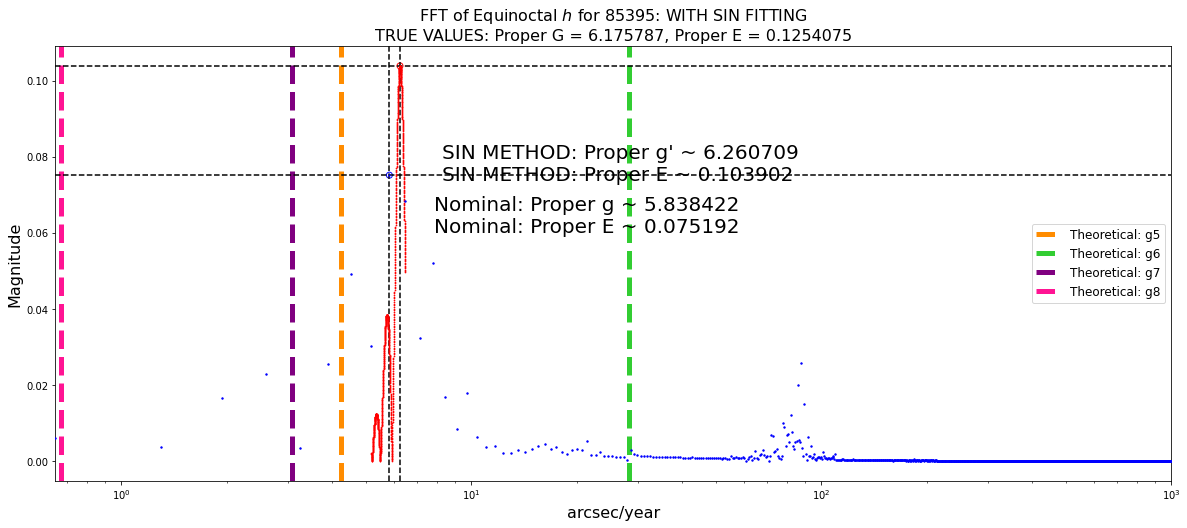

In [16]:
plt.figure(figsize=(20, 8))
def signal_strength(w, signal):
    test_times = z_data['time']
    n = len(signal)
    return abs(sum(np.sin([t* w/3600/rad2Deg for t in test_times]) * signal)/n*2)


plt.axvline(4.2575, c='darkorange', ls ='--', label = 'Theoretical: g5', lw = 5)
plt.axvline(28.2455, c='limegreen', ls ='--', label = 'Theoretical: g6', lw = 5)
plt.axvline(3.0868, c='purple', ls ='--', label = 'Theoretical: g7', lw = 5)
plt.axvline(0.6726, c='deeppink', ls ='--', label = 'Theoretical: g8', lw = 5)

peak_index = np.argmax(psd_h[:n//2])

P_e = psd_h[peak_index]
P_g = freq[peak_index]
plt.scatter(P_g, P_e, facecolors = 'none', edgecolors='blue')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')

plt.text(P_g + 2, P_e  - .015, 'Nominal: Proper g ~ {:.6f}\nNominal: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20)

plt.scatter(freq, psd_h, zorder=100, s=2, c='blue')

more_freqs = np.arange(freq[peak_index-1], freq[peak_index+1], .001)
print(more_freqs[0], more_freqs[-1])

response = [signal_strength(w, z_data['h']) for w in more_freqs]

plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_e = max(response)
P_g = more_freqs[np.argmax(response)]
plt.scatter(P_g, P_e, facecolors = 'none', edgecolors='red')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')
plt.text(P_g + 2, P_e  - .030, 'SIN METHOD: Proper g\' ~ {:.6f}\nSIN METHOD: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20)

plt.gca().set_xscale('log')
plt.legend(fontsize = 12)
plt.title('FFT of Equinoctal $h$ for 85395: WITH SIN FITTING\nTRUE VALUES: Proper G = 6.175787, Proper E = 0.1254075',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(freq[1], 1e3)

In [90]:
sim = rebound.Simulation('../data/sim_inits/2020_12_17_sim.bin')
sim.remove(hash="Mercury")
date = datetime(2020, 12, 17, 0, 0, 0)
sim.add("Psyche", date=date, hash="Vesta")
sim.move_to_hel()
sim.N_active = sim.N
sim.integrator = 'WHFast'
ps = sim.particles
sim.dt = -432000*2 # 5 days of seconds

Searching NASA Horizons for 'Psyche'... Found: Target body name: 16 Psyche (A852 FA).


In [91]:
day = 24*3600
year = 365.25*day
t_max = int(5e6*year) #5 million years in seconds
dt = int(1000*year)
out_times = np.arange(0, -t_max-dt, -dt) # output every 2000 days

In [92]:
n = len(out_times)
print(n)

5001


In [93]:
print(out_times[-1]/year)

-5000000.0


In [94]:
orbit_data = {'Venus': {'orbits':[]}, 'Earth':{'orbits':[]}, 'Mars':{'orbits':[]}, 'Jupiter':{'orbits':[]}, 'Saturn': {'orbits':[]}, 'Uranus':{'orbits':[]}, 'Neptune':{'orbits':[]}, 'Vesta':{'orbits':[]}}
for t in out_times:
    sim.integrate(t)
    for name in orbit_data:
        orbit_data[name]['orbits'].append(ps[name].calculate_orbit(ps["Sun"]))

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

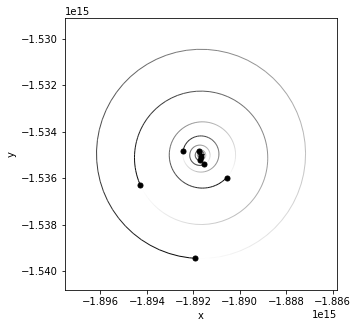

In [95]:
rebound.OrbitPlot(sim)

In [96]:
for name in orbit_data:
    orbit_data[name]['orbits'].reverse() # put orbit aray in order of increasing time
    orbit_data[name]['pomega'] = [orb.pomega for orb in orbit_data[name]['orbits']]
    orbit_data[name]['polar_pomega'] = polarizing_angles(orbit_data[name]['pomega'])
    orbit_data[name]['Omega']  = [orb.Omega for orb in orbit_data[name]['orbits']]
    orbit_data[name]['equi_p'] = [get_pr(orb) for orb in orbit_data[name]['orbits']]
    orbit_data[name]['equi_q'] = [get_qr(orb) for orb in orbit_data[name]['orbits']]
    orbit_data[name]['equi_h'] = [get_hr(orb) for orb in orbit_data[name]['orbits']]
    orbit_data[name]['equi_k'] = [get_kr(orb) for orb in orbit_data[name]['orbits']]
plot_times = [t/sec2year for t in  out_times]
plot_times.reverse()

In [10]:
# plt.scatter(plot_times[::100], orbit_data['Jupiter']['Omega'][::100])

In [97]:
avg_e = np.mean([orb.e for orb in orbit_data['Vesta']['orbits']])
avg_inc = np.mean([np.sin(orb.inc) for orb in orbit_data['Vesta']['orbits']])
print(avg_e, avg_inc)

0.10814795354154219 0.048918587025699414


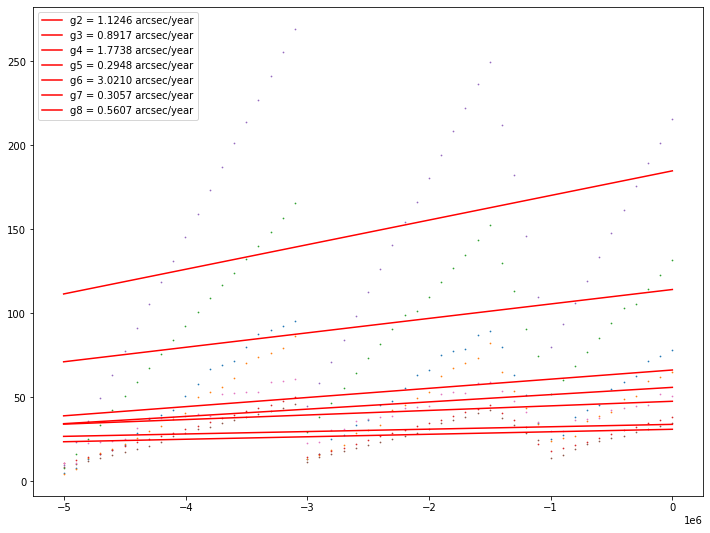

In [98]:
plt.figure(figsize=(12,9))

g_j = {}
j = 2
for name in orbit_data:
    if name == "Vesta": continue
    (g, b), pcov = curve_fit(lin_func, plot_times, orbit_data[name]['polar_pomega'])
    key = 'g{}'.format(j)
    g_j[key] = g
    plt.scatter(plot_times[::100], orbit_data[name]['polar_pomega'][::100], s = 0.5)
    plt.plot(plot_times[::100], lin_func(plot_times[::100], g, b), c = 'red', label = '{} = {:.4f} arcsec/year'.format(key, g*rad2Deg*3600))
    j+=1

plt.legend()

In [99]:
n = len(orbit_data["Vesta"]['equi_h'])
fhat_h = np.fft.fft(orbit_data["Vesta"]['equi_h'], n=n, norm=None)
psd_h = abs(fhat_h)/n*2
fhat_k = np.fft.fft(orbit_data["Vesta"]['equi_k'], n=n, norm=None)
psd_k = abs(fhat_k)/n*2
fhat_p = np.fft.fft(orbit_data["Vesta"]['equi_p'], n=n, norm=None)
psd_p = abs(fhat_p)/n*2
fhat_q = np.fft.fft(orbit_data["Vesta"]['equi_q'], n=n, norm=None)
psd_q = abs(fhat_q)/n*2
freq = (2*np.pi*rad2Deg*3600/(dt*n)*sec2year) * np.arange(n)
print(n)

5001


78.20917951933227 78.72617951933474


(0.25897079311037174, 1000.0)

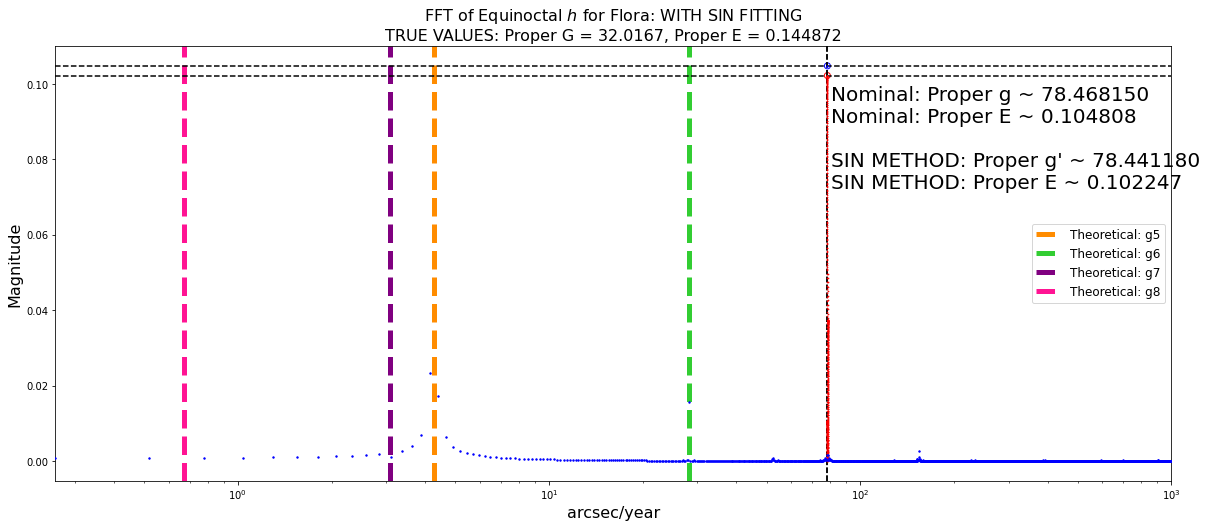

In [105]:
plt.figure(figsize=(20, 8))
def signal_strength(w, signal):
    test_times = plot_times
    n = len(signal)
    return abs(sum(np.sin([t* w/3600/rad2Deg for t in test_times]) * signal)/n*2)

# plt.axvline(5.5964, c='brown', ls ='--', label = 'Theoretical: g1', lw = 5)
# plt.axvline(7.4559, c='darkkhaki', ls ='--', label = 'Theoretical: g2', lw = 5)
# plt.axvline(g_j['g2']*rad2Deg*3600, c='darkkhaki', label='Locally Computed: g2', lw = 3)
# plt.axvline(17.3646, c='darkgreen', ls ='--', label = 'Theoretical: g3', lw = 5)
# plt.axvline(g_j['g3']*rad2Deg*3600, c='darkgreen', label='Locally Computed: g3', lw = 3)
# plt.axvline(17.9156, c='red', ls ='--', label = 'Theoretical: g4', lw = 5)
# plt.axvline(g_j['g4']*rad2Deg*3600, c='red', label='Locally Computed: g4', lw = 3)
plt.axvline(4.2575, c='darkorange', ls ='--', label = 'Theoretical: g5', lw = 5)
# plt.axvline(g_j['g5']*rad2Deg*3600, c='darkorange', label='Locally Computed: g5', lw = 3)
plt.axvline(28.2455, c='limegreen', ls ='--', label = 'Theoretical: g6', lw = 5)
# plt.axvline(g_j['g6']*rad2Deg*3600, c='limegreen', label='Locally Computed: g6', lw = 3)
plt.axvline(3.0868, c='purple', ls ='--', label = 'Theoretical: g7', lw = 5)
# plt.axvline(g_j['g7']*rad2Deg*3600, c='purple', label='Locally Computed: g7', lw = 3)
plt.axvline(0.6726, c='deeppink', ls ='--', label = 'Theoretical: g8', lw = 5)
# plt.axvline(g_j['g8']*rad2Deg*3600, c='deeppink', label='Locally Computed: g8', lw = 3)

peak_index = np.argmax(psd_h[:n//2])

P_e = psd_h[peak_index]
P_g = freq[peak_index]
plt.scatter(P_g, P_e, facecolors = 'none', edgecolors='blue')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')

plt.text(P_g + 2, P_e  - .015, 'Nominal: Proper g ~ {:.6f}\nNominal: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20)

plt.scatter(freq, psd_h, zorder=100, s=2, c='blue')

more_freqs = np.arange(freq[peak_index-1], freq[peak_index+1], .001)
print(more_freqs[0], more_freqs[-1])

response = [signal_strength(w, orbit_data["Vesta"]['equi_h']) for w in more_freqs]

plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_e = max(response)
P_g = more_freqs[np.argmax(response)]
plt.scatter(P_g, P_e, facecolors = 'none', edgecolors='red')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')
plt.text(P_g + 2, P_e  - .030, 'SIN METHOD: Proper g\' ~ {:.6f}\nSIN METHOD: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20)

plt.gca().set_xscale('log')
plt.legend(fontsize = 12)
plt.title('FFT of Equinoctal $h$ for Flora: WITH SIN FITTING\nTRUE VALUES: Proper G = 32.0167, Proper E = 0.144872',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(freq[1], 1e3)

78.20917951933227 78.72617951933474


(0.25897079311037174, 1000.0)

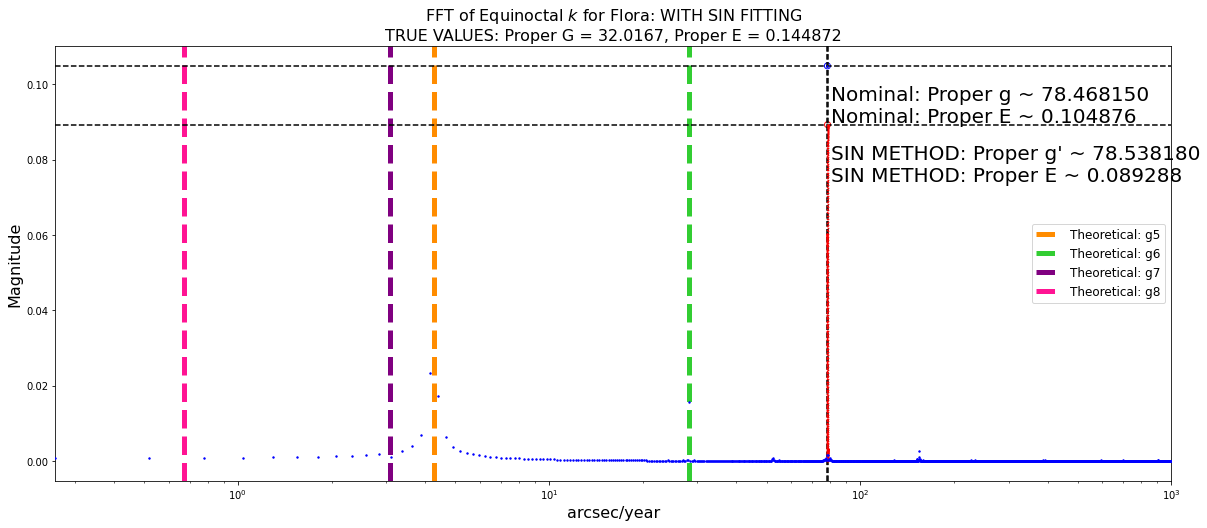

In [107]:
plt.figure(figsize=(20, 8))
def signal_strength(w, signal):
    test_times = plot_times
    n = len(signal)
    return abs(sum(np.sin([t* w/3600/rad2Deg for t in test_times]) * signal)/n*2)

# plt.axvline(5.5964, c='brown', ls ='--', label = 'Theoretical: g1', lw = 5)
# plt.axvline(7.4559, c='darkkhaki', ls ='--', label = 'Theoretical: g2', lw = 5)
# plt.axvline(g_j['g2']*rad2Deg*3600, c='darkkhaki', label='Locally Computed: g2', lw = 3)
# plt.axvline(17.3646, c='darkgreen', ls ='--', label = 'Theoretical: g3', lw = 5)
# plt.axvline(g_j['g3']*rad2Deg*3600, c='darkgreen', label='Locally Computed: g3', lw = 3)
# plt.axvline(17.9156, c='red', ls ='--', label = 'Theoretical: g4', lw = 5)
# plt.axvline(g_j['g4']*rad2Deg*3600, c='red', label='Locally Computed: g4', lw = 3)
plt.axvline(4.2575, c='darkorange', ls ='--', label = 'Theoretical: g5', lw = 5)
# plt.axvline(g_j['g5']*rad2Deg*3600, c='darkorange', label='Locally Computed: g5', lw = 3)
plt.axvline(28.2455, c='limegreen', ls ='--', label = 'Theoretical: g6', lw = 5)
# plt.axvline(g_j['g6']*rad2Deg*3600, c='limegreen', label='Locally Computed: g6', lw = 3)
plt.axvline(3.0868, c='purple', ls ='--', label = 'Theoretical: g7', lw = 5)
# plt.axvline(g_j['g7']*rad2Deg*3600, c='purple', label='Locally Computed: g7', lw = 3)
plt.axvline(0.6726, c='deeppink', ls ='--', label = 'Theoretical: g8', lw = 5)
# plt.axvline(g_j['g8']*rad2Deg*3600, c='deeppink', label='Locally Computed: g8', lw = 3)

peak_index = np.argmax(psd_k[:n//2])

P_e = psd_k[peak_index]
P_g = freq[peak_index]
plt.scatter(P_g, P_e, facecolors = 'none', edgecolors='blue')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')

plt.text(P_g + 2, P_e  - .015, 'Nominal: Proper g ~ {:.6f}\nNominal: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20)

plt.scatter(freq, psd_k, zorder=100, s=2, c='blue')

more_freqs = np.arange(freq[peak_index-1], freq[peak_index+1], .001)
print(more_freqs[0], more_freqs[-1])

response = [signal_strength(w, orbit_data["Vesta"]['equi_k']) for w in more_freqs]

plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_e = max(response)
P_g = more_freqs[np.argmax(response)]
plt.scatter(P_g, P_e, facecolors = 'none', edgecolors='red')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')
plt.text(P_g + 2, P_e  - .015, 'SIN METHOD: Proper g\' ~ {:.6f}\nSIN METHOD: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20)

plt.gca().set_xscale('log')
plt.legend(fontsize = 12)
plt.title('FFT of Equinoctal $k$ for Flora: WITH SIN FITTING\nTRUE VALUES: Proper G = 32.0167, Proper E = 0.144872',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(freq[1], 1e3)

74.3246176226767 74.84161762267917


(0.25897079311037174, 1000.0)

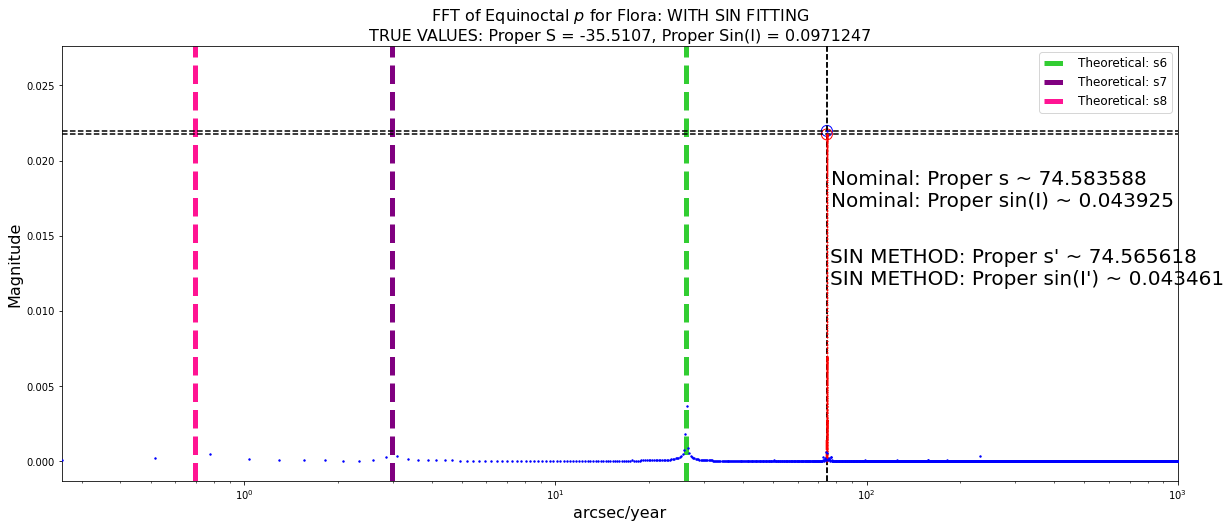

In [110]:
def signal_strength(w, signal):
    test_times = plot_times
    n = len(signal)
    return abs(sum(np.sin([t* w/3600/rad2Deg for t in test_times]) * signal)/n*2)
plt.figure(figsize=(20, 8))

# plt.axvline(5.6174, c='brown', ls ='--', label = 'Theoretical: s1', lw = 5)
# plt.axvline(7.0795, c='darkkhaki', ls ='--', label = 'Theoretical: s2', lw = 5)
# plt.axvline(g_j['g2']*rad2Deg*3600, c='darkkhaki', label='Locally Computed: s2', lw = 3)
# plt.axvline(18.8512, c='darkgreen', ls ='--', label = 'Theoretical: s3', lw = 5)
# plt.axvline(g_j['g3']*rad2Deg*3600, c='darkgreen', label='Locally Computed: s3', lw = 3)
# plt.axvline(17.7482, c='red', ls ='--', label = 'Theoretical: s4', lw = 5)
# plt.axvline(g_j['g4']*rad2Deg*3600, c='red', label='Locally Computed: s4', lw = 3)
# plt.axvline(0, c='darkorange', ls ='--', label = 'Theoretical: s5', lw = 5)
# plt.axvline(g_j['g5']*rad2Deg*3600, c='darkorange', label='Locally Computed: s5', lw = 3)
plt.axvline(26.3450, c='limegreen', ls ='--', label = 'Theoretical: s6', lw = 5)
# plt.axvline(g_j['g6']*rad2Deg*3600, c='limegreen', label='Locally Computed: s6', lw = 3)
plt.axvline(2.9927, c='purple', ls ='--', label = 'Theoretical: s7', lw = 5)
# plt.axvline(g_j['g7']*rad2Deg*3600, c='purple', label='Locally Computed: s7', lw = 3)
plt.axvline(0.6925, c='deeppink', ls ='--', label = 'Theoretical: s8', lw = 5)
# plt.axvline(g_j['g8']*rad2Deg*3600, c='deeppink', label='Locally Computed: s8', lw = 3)

peak_index = 1+np.argmax(psd_p[1:n//2])

P_I = psd_p[peak_index]
P_s = freq[peak_index]
plt.scatter(P_s, P_I, s=120, facecolors='none', edgecolors='blue')
plt.axhline(P_I, ls = '--', c='k')
plt.axvline(P_s, ls = '--', c='k')
plt.text(P_s + 2, P_I  - .005, 'Nominal: Proper s ~ {:.6f}\nNominal: Proper sin(I) ~ {:.6f}'.format(P_s, np.sin(np.arctan(P_I)*2)), fontsize = 20)

plt.scatter(freq, psd_p, zorder=100, s=2, c='blue')

more_freqs = np.arange(freq[peak_index-1], freq[peak_index+1], .001)
print(more_freqs[0], more_freqs[-1])

response = [signal_strength(w, orbit_data["Vesta"]['equi_p']) for w in more_freqs]

plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_I = max(response)
P_s = more_freqs[np.argmax(response)]
plt.scatter(P_s, P_I, s=120, facecolors='none', edgecolors='red')
plt.axhline(P_I, ls = '--', c='k')
plt.axvline(P_s, ls = '--', c='k')
plt.text(P_s + 2, P_I  - .01, 'SIN METHOD: Proper s\' ~ {:.6f}\nSIN METHOD: Proper sin(I\') ~ {:.6f}'.format(P_s, np.sin(np.arctan(P_I)*2)), fontsize = 20)

plt.gca().set_xscale('log')
plt.legend(fontsize = 12)
plt.title('FFT of Equinoctal $p$ for Flora: WITH SIN FITTING\nTRUE VALUES: Proper S = -35.5107, Proper Sin(I) = 0.0971247',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(freq[1], 1e3)

74.3246176226767 74.84161762267917


(0.25897079311037174, 1000.0)

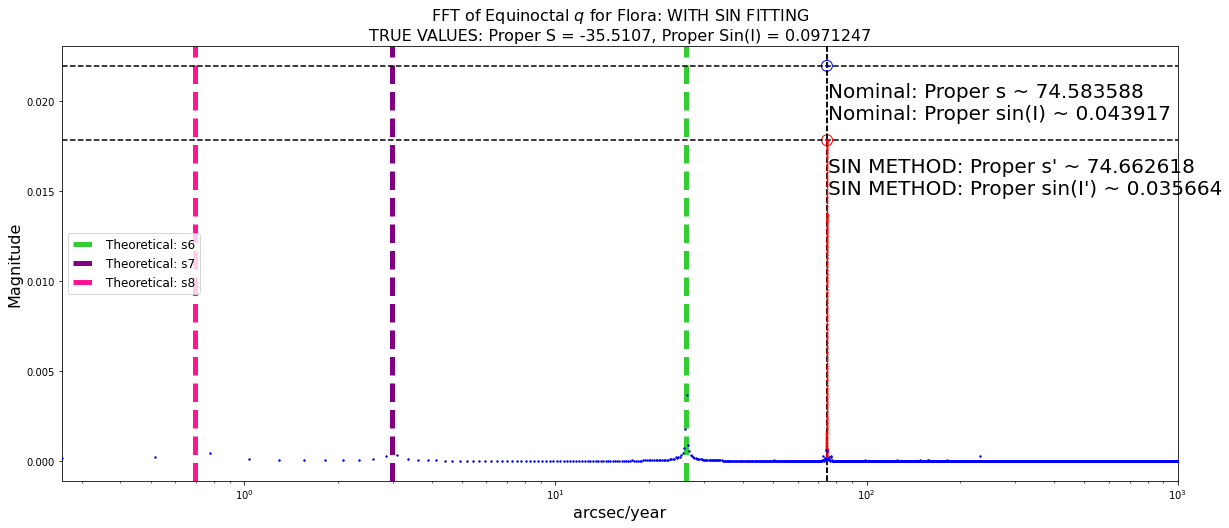

In [113]:
def signal_strength(w, signal):
    test_times = plot_times
    n = len(signal)
    return abs(sum(np.sin([t* w/3600/rad2Deg for t in test_times]) * signal)/n*2)
plt.figure(figsize=(20, 8))

# plt.axvline(5.6174, c='brown', ls ='--', label = 'Theoretical: s1', lw = 5)
# plt.axvline(7.0795, c='darkkhaki', ls ='--', label = 'Theoretical: s2', lw = 5)
# plt.axvline(g_j['g2']*rad2Deg*3600, c='darkkhaki', label='Locally Computed: s2', lw = 3)
# plt.axvline(18.8512, c='darkgreen', ls ='--', label = 'Theoretical: s3', lw = 5)
# plt.axvline(g_j['g3']*rad2Deg*3600, c='darkgreen', label='Locally Computed: s3', lw = 3)
# plt.axvline(17.7482, c='red', ls ='--', label = 'Theoretical: s4', lw = 5)
# plt.axvline(g_j['g4']*rad2Deg*3600, c='red', label='Locally Computed: s4', lw = 3)
# plt.axvline(0, c='darkorange', ls ='--', label = 'Theoretical: s5', lw = 5)
# plt.axvline(g_j['g5']*rad2Deg*3600, c='darkorange', label='Locally Computed: s5', lw = 3)
plt.axvline(26.3450, c='limegreen', ls ='--', label = 'Theoretical: s6', lw = 5)
# plt.axvline(g_j['g6']*rad2Deg*3600, c='limegreen', label='Locally Computed: s6', lw = 3)
plt.axvline(2.9927, c='purple', ls ='--', label = 'Theoretical: s7', lw = 5)
# plt.axvline(g_j['g7']*rad2Deg*3600, c='purple', label='Locally Computed: s7', lw = 3)
plt.axvline(0.6925, c='deeppink', ls ='--', label = 'Theoretical: s8', lw = 5)
# plt.axvline(g_j['g8']*rad2Deg*3600, c='deeppink', label='Locally Computed: s8', lw = 3)

peak_index = 1+np.argmax(psd_q[1:n//2])

P_I = psd_q[peak_index]
P_s = freq[peak_index]
plt.scatter(P_s, P_I, s=120, facecolors='none', edgecolors='blue')
plt.axhline(P_I, ls = '--', c='k')
plt.axvline(P_s, ls = '--', c='k')
plt.text(P_s + .7, P_I  - .003, 'Nominal: Proper s ~ {:.6f}\nNominal: Proper sin(I) ~ {:.6f}'.format(P_s, np.sin(np.arctan(P_I)*2)), fontsize = 20)

plt.scatter(freq, psd_q, zorder=100, s=2, c='blue')

more_freqs = np.arange(freq[peak_index-1], freq[peak_index+1], .001)
print(more_freqs[0], more_freqs[-1])

response = [signal_strength(w, orbit_data["Vesta"]['equi_q']) for w in more_freqs]

plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_I = max(response)
P_s = more_freqs[np.argmax(response)]
plt.scatter(P_s, P_I, s=120, facecolors='none', edgecolors='red')
plt.axhline(P_I, ls = '--', c='k')
plt.axvline(P_s, ls = '--', c='k')
plt.text(P_s + .7, P_I  - .003, 'SIN METHOD: Proper s\' ~ {:.6f}\nSIN METHOD: Proper sin(I\') ~ {:.6f}'.format(P_s, np.sin(np.arctan(P_I)*2)), fontsize = 20)


plt.gca().set_xscale('log')
plt.legend(fontsize = 12, loc=6)
plt.title('FFT of Equinoctal $q$ for Flora: WITH SIN FITTING\nTRUE VALUES: Proper S = -35.5107, Proper Sin(I) = 0.0971247',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(freq[1], 1e3)

(20.0, 100.0)

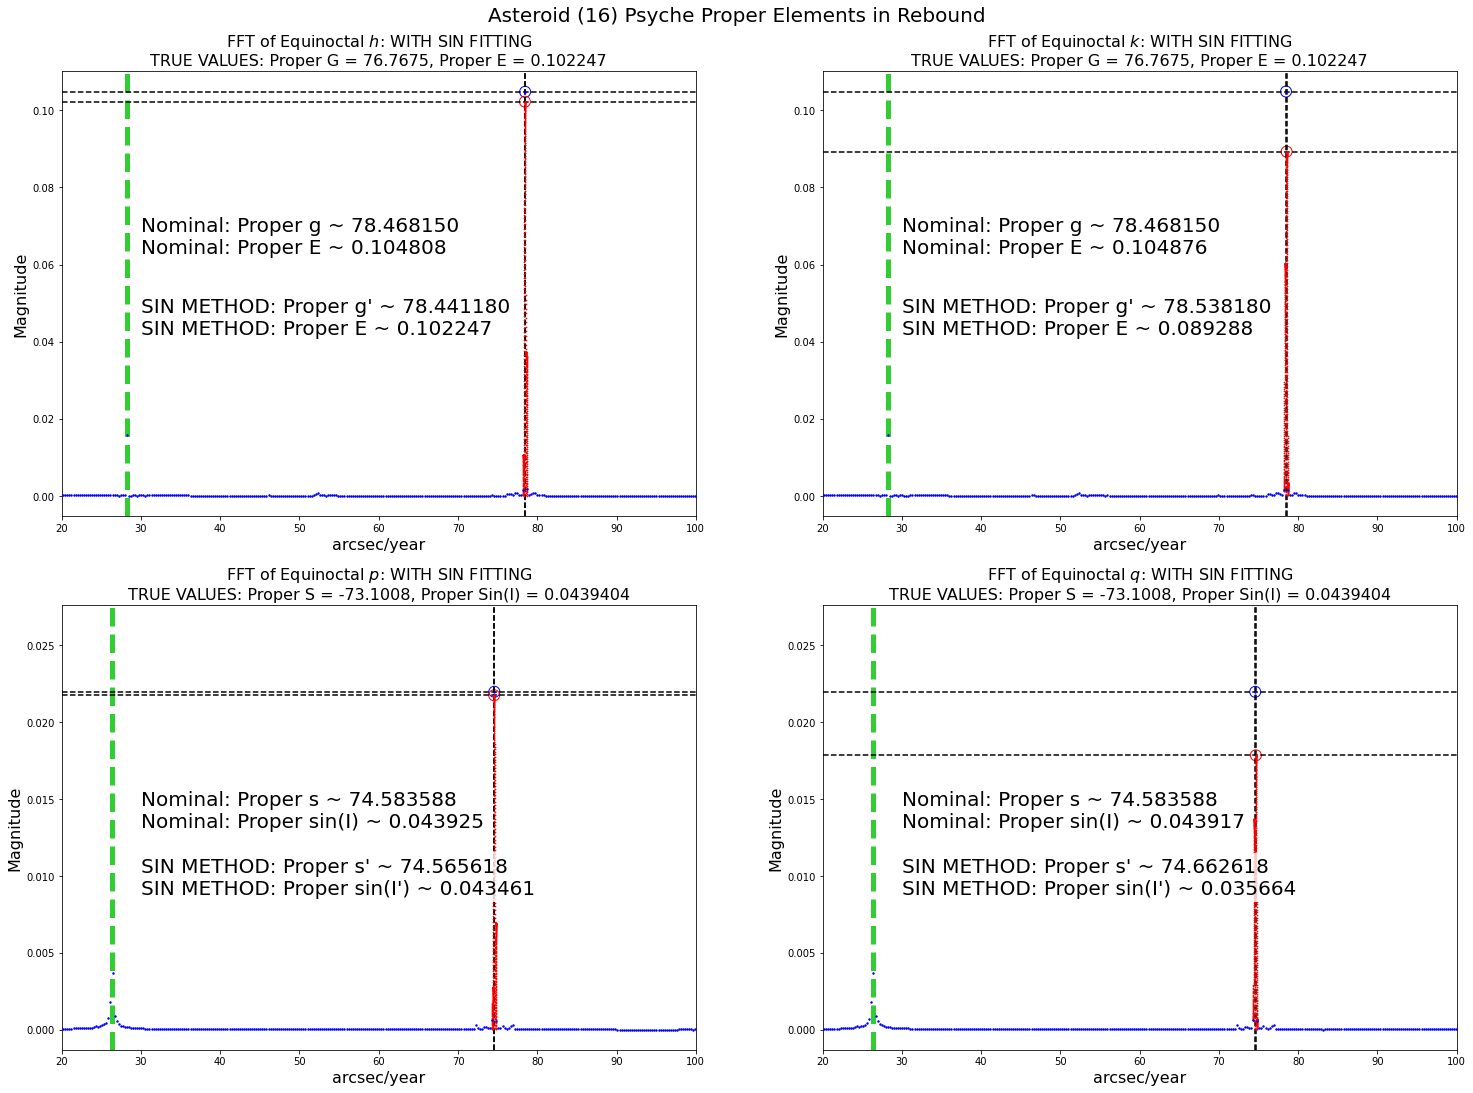

In [123]:
plt.figure(figsize=(25, 18))
plt.suptitle("Asteroid (16) Psyche Proper Elements in Rebound", fontsize = 20, y=.93)

plt.subplot(2, 2, 1)
ax1 = plt.gca()
plt.axvline(28.2455, c='limegreen', ls ='--', label = 'Theoretical: g6', lw = 5)
peak_index = 1 + np.argmax(psd_h[1:n//2])
P_e = psd_h[peak_index]
P_g = freq[peak_index]
plt.scatter(P_g, P_e, s=120, facecolors='none', edgecolors='blue')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')
t = plt.text(30, psd_h[peak_index]*.6, 'Nominal: Proper g ~ {:.6f}\nNominal: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.scatter(freq, psd_h, zorder=100, s=2, c='blue')
more_freqs = np.arange(freq[peak_index-1], freq[peak_index+1], .001)
response = [signal_strength(w, orbit_data["Vesta"]['equi_h']) for w in more_freqs]
plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_e = max(response)
P_g = more_freqs[np.argmax(response)]
plt.scatter(P_g, P_e, s=120, facecolors='none', edgecolors='red')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')
t = plt.text(30, psd_h[peak_index]*.4, 'SIN METHOD: Proper g\' ~ {:.6f}\nSIN METHOD: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.title('FFT of Equinoctal $h$: WITH SIN FITTING\nTRUE VALUES: Proper G = 76.7675, Proper E = 0.102247',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(20, 100)

plt.subplot(2, 2, 2, sharey=ax1)
ax2=plt.gca()
plt.axvline(28.2455, c='limegreen', ls ='--', label = 'Theoretical: g6', lw = 5)
peak_index = 1 + np.argmax(psd_k[1:n//2])
P_e = psd_k[peak_index]
P_g = freq[peak_index]
plt.scatter(P_g, P_e, s=120, facecolors='none', edgecolors='blue')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')
t = plt.text(30, psd_k[peak_index]*.6, 'Nominal: Proper g ~ {:.6f}\nNominal: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.scatter(freq, psd_k, zorder=100, s=2, c='blue')
more_freqs = np.arange(freq[peak_index-1], freq[peak_index+1], .001)
response = [signal_strength(w, orbit_data["Vesta"]['equi_k']) for w in more_freqs]
plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_e = max(response)
P_g = more_freqs[np.argmax(response)]
plt.scatter(P_g, P_e, s=120, facecolors='none', edgecolors='red')
plt.axhline(P_e, ls = '--', c='k')
plt.axvline(P_g, ls = '--', c='k')
t = plt.text(30, psd_k[peak_index]*.4, 'SIN METHOD: Proper g\' ~ {:.6f}\nSIN METHOD: Proper E ~ {:.6f}'.format(P_g, P_e), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.title('FFT of Equinoctal $k$: WITH SIN FITTING\nTRUE VALUES: Proper G = 76.7675, Proper E = 0.102247',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(20, 100)

plt.subplot(2, 2, 3, sharex=ax1)
ax3=plt.gca()
plt.axvline(26.3450, c='limegreen', ls ='--', label = 'Theoretical: s6', lw = 5)
peak_index = 1 + np.argmax(psd_p[1:n//2])
P_I = psd_p[peak_index]
P_s = freq[peak_index]
plt.scatter(P_s, P_I, s=120, facecolors='none', edgecolors='blue')
plt.axhline(P_I, ls = '--', c='k')
plt.axvline(P_s, ls = '--', c='k')
t = plt.text(30, psd_p[peak_index]*.6, 'Nominal: Proper s ~ {:.6f}\nNominal: Proper sin(I) ~ {:.6f}'.format(P_s, np.sin(np.arctan(P_I)*2)), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.scatter(freq, psd_p, zorder=100, s=2, c='blue')
more_freqs = np.arange(freq[peak_index-1], freq[peak_index+1], .001)
response = [signal_strength(w, orbit_data["Vesta"]['equi_p']) for w in more_freqs]
plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_I = max(response)
P_s = more_freqs[np.argmax(response)]
plt.scatter(P_s, P_I, s=120, facecolors='none', edgecolors='red')
plt.axhline(P_I, ls = '--', c='k')
plt.axvline(P_s, ls = '--', c='k')
t = plt.text(30, psd_p[peak_index]*.4, 'SIN METHOD: Proper s\' ~ {:.6f}\nSIN METHOD: Proper sin(I\') ~ {:.6f}'.format(P_s, np.sin(np.arctan(P_I)*2)), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.title('FFT of Equinoctal $p$: WITH SIN FITTING\nTRUE VALUES: Proper S = -73.1008, Proper Sin(I) = 0.0439404',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(20, 100)

plt.subplot(2, 2, 4, sharey=ax3, sharex=ax2)
ax4=plt.gca()
plt.axvline(26.3450, c='limegreen', ls ='--', label = 'Theoretical: s6', lw = 5)
peak_index = 1 + np.argmax(psd_q[1:n//2])
P_I = psd_q[peak_index]
P_s = freq[peak_index]
plt.scatter(P_s, P_I, s=120, facecolors='none', edgecolors='blue')
plt.axhline(P_I, ls = '--', c='k')
plt.axvline(P_s, ls = '--', c='k')
t = plt.text(30, psd_q[peak_index]*.6, 'Nominal: Proper s ~ {:.6f}\nNominal: Proper sin(I) ~ {:.6f}'.format(P_s, np.sin(np.arctan(P_I)*2)), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.scatter(freq, psd_q, zorder=100, s=2, c='blue')
more_freqs = np.arange(freq[peak_index-1], freq[peak_index+1], .001)
response = [signal_strength(w, orbit_data["Vesta"]['equi_q']) for w in more_freqs]
plt.scatter(more_freqs, response, zorder=50, s=.5, c='red')
P_I = max(response)
P_s = more_freqs[np.argmax(response)]
plt.scatter(P_s, P_I, s=120, facecolors='none', edgecolors='red')
plt.axhline(P_I, ls = '--', c='k')
plt.axvline(P_s, ls = '--', c='k')
t = plt.text(30, psd_q[peak_index]*.4, 'SIN METHOD: Proper s\' ~ {:.6f}\nSIN METHOD: Proper sin(I\') ~ {:.6f}'.format(P_s, np.sin(np.arctan(P_I)*2)), fontsize = 20, zorder=500)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.title('FFT of Equinoctal $q$: WITH SIN FITTING\nTRUE VALUES: Proper S = -73.1008, Proper Sin(I) = 0.0439404',fontsize=16)
plt.xlabel('arcsec/year',fontsize=16)
plt.ylabel("Magnitude",fontsize=16)
plt.xlim(20, 100)


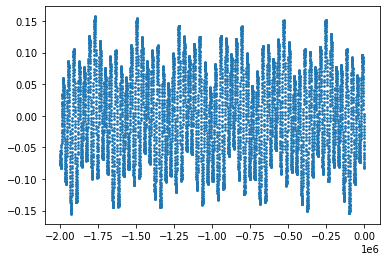

In [40]:
plt.scatter(plot_times[::100], orbit_data['Vesta']['equi_h'][::100], s = 3)

In [25]:
max((fhat_h * np.conj(fhat_h) / n)[:-1000])

(1799.200345119974+0j)

In [27]:
list(fhat_h * np.conj(fhat_h) / n).index(max(fhat_h * np.conj(fhat_h) / n))

58

In [28]:
freq[58]

37.55822373959789

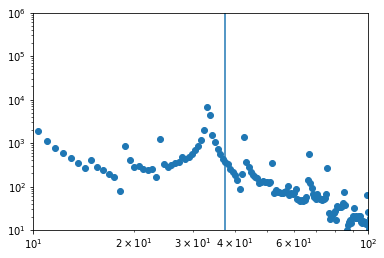

In [52]:
fhat_e = np.fft.fft([orb.e for orb in orbit_data['Vesta']['orbits']])
# plt.scatter(freq, fhat_e * np.conj(fhat_e))
plt.scatter(freq, abs(fhat_e))
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlim(10, 100)
plt.ylim(1e1, 1e6)
plt.axvline(freq[58])

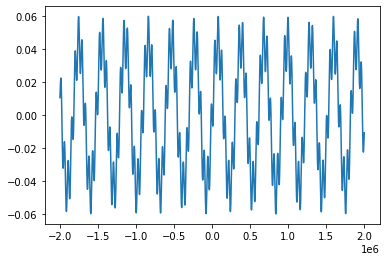

In [326]:
test_times = np.arange(-2000000, 2000000, 100)
h = 0.044187*np.sin([t* 4.2575/3600/rad2Deg for t in test_times]) - 15700e-6*np.sin([t* 28.2455/3600/rad2Deg for t in test_times])
plt.plot(test_times, h)

Text(0.5, 1.0, 'Component Amplitude = 2*F/n')

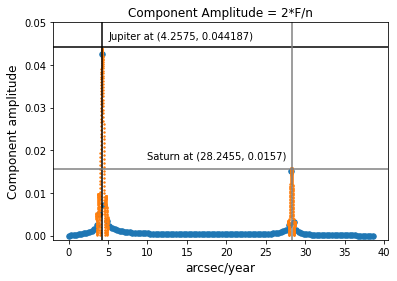

In [354]:
fft_j = np.fft.rfft(h)
n = len(test_times)
freq = (2*np.pi*rad2Deg*3600/(100*n)) * np.arange(n)
# psd = [(f/n**2)**.5*2 for f in fft_j * np.conj(fft_j)]
psd = [(f/n)*2 for f in abs(fft_j)]
plt.scatter(freq[:120], psd[:120], s=30)
plt.scatter(ws, response, s=2)
plt.xlabel('arcsec/year', fontsize=12)
plt.ylabel('Component amplitude', fontsize=12)
plt.axvline(4.2575, c = 'k')
plt.axhline(0.044187, c = 'k')
plt.text(5, 0.046, 'Jupiter at (4.2575, 0.044187)')
plt.axvline(28.2455, c = 'grey')
plt.axhline(15700e-6, c = 'grey')
plt.text(10, 0.018, 'Saturn at (28.2455, 0.0157)')
plt.ylim(-.001, 0.05)

plt.title('Component Amplitude = 2*F/n', fontsize=12)

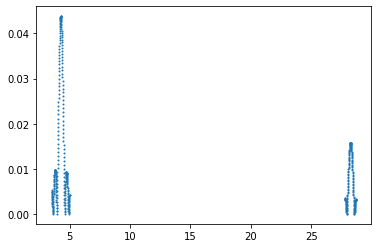

In [351]:
def singnal_strength(w):
    return abs(sum(np.sin([t* w/3600/rad2Deg for t in test_times[:]]) * h)/len(h)*2)
ws = np.arange(3.5,5,.005)
ws = np.append(ws,np.arange(27.8, 28.7, .005))
response = []
for w in ws:
    response.append(singnal_strength(w))
plt.scatter(ws, response, s=1)

In [349]:
n_ws = len(ws)
ws[np.argmax(response[:n_ws//2])], ws[n_ws//2 + np.argmax(response[n_ws//2:])], max(response[:n_ws//2]), max(response[n_ws//2:]), abs(max(psd)), abs(max(psd[60:]))

(4.254999999999995,
 28.24499999999995,
 0.04380938728919215,
 0.01577063593663069,
 0.04252845047552017,
 0.015025276568414122)

(0.1, 40)

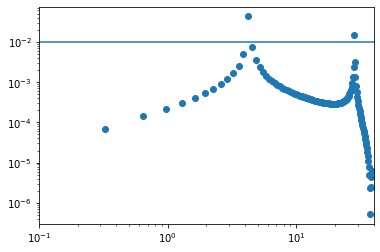

In [356]:
plt.scatter(freq[:120], psd[:120])
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
cutoff = .01
plt.axhline(cutoff)
plt.xlim(.1, 40)

In [358]:
feature = False
cutoff = 0.01
for i, f in enumerate(psd[1:500]):
    if f > cutoff and not feature:
        feature = True
        feature_start = i
        amp = [f**2]
    elif f > cutoff and feature:
        amp.append(f**2)
    elif f < cutoff and feature:
        feature_end = i-1
        print('There is a feature at frquencies {} - {} arcsec/year'.format(freq[feature_start], freq[feature_end]))
        print("Summed Feature Amplitude: {}".format(np.sqrt(sum(amp))))
        feature = False
    else:
        continue


There is a feature at frquencies 3.888 - 3.888 arcsec/year
Summed Feature Amplitude: 0.04252845047552016
There is a feature at frquencies 27.864 - 27.864 arcsec/year
Summed Feature Amplitude: 0.015025276568414125


In [321]:
np.sin(np.arctan(0.05419844747733307)*2)

0.10807941473157193

In [169]:
psd[7] , psd[43], np.abs(psd[7]) , np.abs(psd[43])

((0.003838043992751676+0j),
 (0.0005154085770989916+0j),
 0.003838043992751676,
 0.0005154085770989916)

In [93]:
11143.085177563435/3151.18236487165

3.536160046394935

In [135]:
0.044187,15700e-6

(0.044187, 0.0157)

In [237]:
indx = list(psd).index(max(psd[20:120]))
indx, fft_j[indx], psd[indx]

(87, (0.01056134777377988-300.5055311826918j), 0.015025276568414125)

In [68]:
freq[7]

4.532889072020436

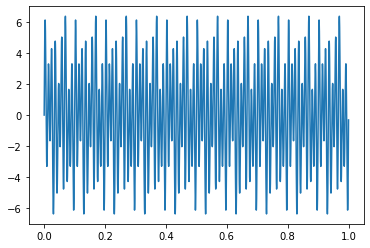

In [117]:
t = np.arange(0, 1, .0001)
f = np.sin(20*2*np.pi*t) + 2*np.sin(60*2*np.pi*t) + 4*np.sin(90*2*np.pi*t)
plt.plot(t, f)

10000


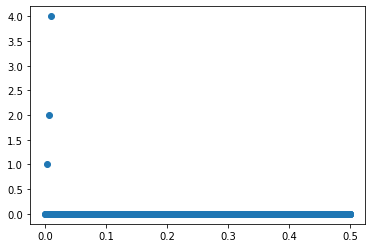

In [120]:
n = len(t)
print(n)
fhat = np.fft.fft(f)
psd = (fhat*np.conj(fhat))
freq = 1/n*np.arange(n)

plt.scatter(freq[:n//2], [(p/n**2)**.5 * 2 for p in psd[:n//2]])

In [140]:
twopi = 2*np.pi
fs = 1/dt*year # sampling frequency
pass_band_boundary = 10000 # Perodic perturbations < 1e4 year should be filtered out
dark_band_boundary = 281.49  # allow some gap for filter
w_pass = 1/pass_band_boundary*fs
w_max = 1/dark_band_boundary*fs
width = (w_max-w_pass)/fs

In [141]:
fs, w_pass, w_max, width

(0.182625,
 1.8262500000000003e-05,
 0.0006487797079825216,
 0.0034525240683505633)

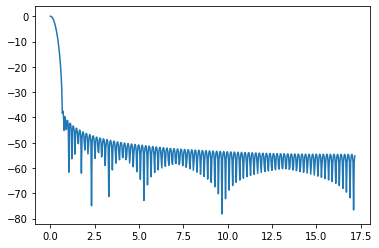

In [143]:
b = signal.firwin(171, w_pass, width=width*2 , fs=fs); a=1
w, H = signal.freqz(b, a) # calculate frequency response
plt.plot(w/fs, 10*np.log10(abs(H)))
# plt.xlim(0, 5e-3)
# plt.ylim(-6, 0)

/Users/bethclark/Projects/Flora_Family/venv/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bethclark/Projects/Flora_Family/venv/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(1e-05, 1.0)

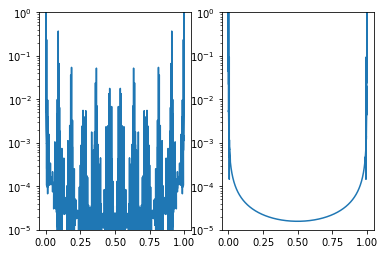

In [147]:
x_n = [get_hr(o) for o in orbit_data['Jupiter']]
n = len(x_n)
fhat = np.fft.fft(x_n)
PSD = fhat * np.conj(fhat) / n
freq = (1/(n)) * np.arange(n)

plt.subplot(1,2,1)
plt.semilogy(freq, np.sqrt(PSD))
plt.ylim(1e-5, 1e0)
# plt.xlim(0, .06)

f_lp = signal.filtfilt(b, 1, x_n)
fhat_lp = np.fft.fft(f_lp)
PSD_lp = fhat_lp * np.conj(fhat_lp) / n

plt.subplot(1,2,2)
plt.semilogy(freq, np.sqrt(PSD_lp))
plt.ylim(1e-5, 1e0)
# plt.xlim(0, .06)

/Users/bethclark/Projects/Flora_Family/venv/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 0.6)

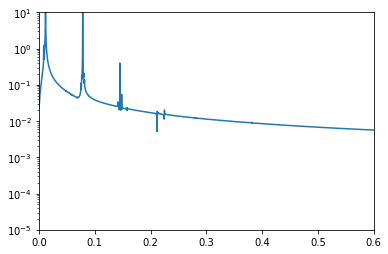

In [156]:
plt.semilogy((3600/(5.4757*n)) * np.arange(n), np.sqrt(PSD_lp))
plt.ylim(1e-5, 1e1)
plt.xlim(0, .6)

In [148]:
n

1826250